In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from optimizer import Adam


sigma_distribution = 180
theta0=90

sigma_res_noise = 0.005
sigma_S = 0.002

spatial_res = 5

def encode(pos, res = None):
    if res is None: res = 10

    pos = np.array (pos)
    if len (pos.shape) == 1: pos = pos.reshape (-1, 1)
    shape = pos.shape

    x =  np.clip(pos.T, -1,1).T

    mu_x = np.linspace (-1.,1., num = res).T
    s_x= np.diff ((-1.,1.), axis = 0).T / (res)

    enc_x = np.exp (-0.5 * ((x.reshape (-1, 1) - mu_x) / s_x)**2).T

    return np.array (enc_x)


def encode_state(pos, res = None):
    if res is None: res = spatial_res

    pos = np.array (pos)
    if len (pos.shape) == 1: pos = pos.reshape (-1, 1)
    
    x =  np.clip(pos[0].T, -1,1).T

    mu_x = np.linspace (-1.,1., num = res).T
    s_x= np.diff ((-1.,1.), axis = 0).T / (res)
    enc_x = np.exp (-0.5 * ((x.reshape (-1, 1) - mu_x) / s_x)**2).T

    y =  np.clip(pos[1].T, -1,1).T
    mu_y = np.linspace (-1.,1., num = res).T
    s_y= np.diff ((-1.,1.), axis = 0).T / (res)

    enc_y = np.exp (-0.5 * ((y.reshape (-1, 1) - mu_y) / s_y)**2).T

    return np.array ([enc_x,enc_y])



In [2]:
import matplotlib.cm as cm


class Environment:
    def __init__(self):
        self.agent_position = np.array([0, 0])  # Agent starts at the center
        self.food_position = self._generate_food_position(0,0)
        self.square_size = 2

    def _generate_food_position(self,x,y,theta0=45):
        #return np.random.uniform(-1, 1, size=(2,))
        sx,sy=[sigma_distribution,sigma_distribution]
        #return np.random.normal([x,y], [sx,sy], size=(2,))
        theta = np.random.uniform(theta0 - sigma_distribution, theta0 + sigma_distribution)/180*np.pi
        return .5*np.cos(theta),.5*np.sin(theta)
    
    def reset(self,x,y,theta0=45):
        agent.agent_position = np.array([0, 0])  # Reset agent position
        self.food_position = np.round(self._generate_food_position(x,y,theta0), decimals=1)  # Generate new food position
        print(self.food_position)

    def reset_inner(self):
        self.agent_position = np.array([0, 0])  # Reset agent position
        #self.food_position = self._generate_food_position()  # Generate new food position

    def step(self, action):
        # Define possible actions: 0 for moving left, 1 for moving right, 2 for moving up, 3 for moving down
        if action == 0:
            self.agent_position[0] -= 0.1
        elif action == 1:
            self.agent_position[0] += 0.1
        elif action == 2:
            self.agent_position[1] += 0.1
        elif action == 3:
            self.agent_position[1] -= 0.1

        # Clip agent position to be within the square
        self.agent_position = np.clip(self.agent_position, -self.square_size / 2, self.square_size / 2)

        # Calculate reward
        distance_to_food = np.linalg.norm(self.agent_position - self.food_position)
        reward = 0  # Reward is handled by the agent
        done = False
        #reward = -.1
        #Check if the agent reached the food

        if distance_to_food < 0.15/2:
            reward += 10  # Reward for reaching the food
            
        if distance_to_food < 0.075/2:
            reward += 5  # Additional reward for getting close to the food
            done = True
            
        return reward, done

    def render(self):
        plt.figure(figsize=(5, 5))
        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5)
        plt.plot(self.agent_position[0], self.agent_position[1], 'bo', markersize=10, label='Agent')
        plt.plot(self.food_position[0], self.food_position[1], 'rx', markersize=10, label='Food')
        plt.legend()
        plt.title('Agent Environment')
        plt.grid(True)
        plt.show()

        
class LinearAgent:
    def __init__(self, learning_rate=2.):
        self.weights = np.random.rand(4, 2*spatial_res)  # Weights for the linear policy
        self.learning_rate = learning_rate

    def policy(self, state):
        logits = np.dot(self.weights, state)
        probs = np.exp(logits) / np.sum(np.exp(logits))  # Softmax
        return probs.reshape(-1)  # Ensure action_probs is one-dimensional

    def update(self, states, actions, rewards):
        for i in range(len(states)):
            state = states[i]
            action = actions[i]
            reward = rewards[i]

            gamma_pg = 0.

            probs = self.policy(state)
            probs[action] -= 1  # Gradient of log probability
            self.updates_filt = self.updates_filt*gamma_pg + (1.-gamma_pg)* probs[:, None] @ state.reshape(1, -1)
            #self.weights -= reward*self.learning_rate * self.updates_filt
            dw = -reward*self.learning_rate * self.updates_filt*0.02
            #self.weights_0 -= reward*self.learning_rate * self.updates_filt*0.02

            #print(self.updates_filt)
        return dw,state,probs


# Example usage:
env = Environment()
agent = LinearAgent()

agent.weights_0 = np.copy(agent.weights)

total_rewards = []
rew_to_plot = []



In [3]:

ERRORS = []

from goal_onr import RESERVOIRE_SIMPLE_NL
from goal_onr import RESERVOIRE_SIMPLE_NL_MULT

N, I, O, TIME = 200, 15, 7, 600
shape = (N, I, O, TIME)

dt = .005# / T;
tau_m_f = 20. * dt
tau_m_s = 20. * dt
tau_s = 2. * dt
tau_ro = .001 * dt
beta_s  = np.exp (-dt / tau_s)
beta_ro = np.exp (-dt / tau_ro)
sigma_teach = 0.
sigma_input = .06
sigma_rec = 0.5/np.sqrt(N)
offT = 1
dv = 5.
alpha_rout = .0005;#0.1#.00002;
alpha_pg = 0.0005
alpha = 0.
Vo = 0
h = 0
s_inh = 0
sigma_output = .1

n_electrodes = 85
n_pca = n_electrodes

# Here we build the dictionary of the simulation parameters
par = {'tau_m_f' : tau_m_f,'tau_m_s' : tau_m_s, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'beta_ro' : beta_ro,
    'dv' : dv, 'alpha' : alpha, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
    'N' : N, 'T' : TIME, 'dt' : dt, 'offT' : offT, 'alpha_rout' : alpha_rout,
    'sigma_input' : sigma_input, 'sigma_teach' : sigma_teach,'sigma_rec' : sigma_rec, 'shape' : shape,'sigma_output':sigma_output};

# Here we init our model

# scalar product network
N = 500
gamma = 0.#.5
input_dim = 5
e_encoding_dim = 10
par['tau_m_s'] = 1.*dt
par['tau_m_f'] = 1.*dt
par['sigma_input'] = .01
par['sigma_rec'] = .95/np.sqrt(N)
shape = ( N , 4 * 2*spatial_res + 2*spatial_res, 4 , TIME )
par['shape']=shape
network_reservoire = RESERVOIRE_SIMPLE_NL_MULT (par)
network_reservoire.Jin_mult = np.random.normal(0,0.1,size=(N,2))

# reservoire network
gamma_state = 3.#1.5
shape = ( input_dim , 1, 1 , TIME )
par['sigma_rec'] = .95/np.sqrt(input_dim)
par['shape']=shape
par['tau_m_s'] = 5.*dt
par['tau_m_f'] = 5.*dt
network_reservoire_y = RESERVOIRE_SIMPLE_NL_MULT (par)
network_reservoire_y.adam = Adam (alpha = 0.005, drop = .99, drop_time = 10000)
network_reservoire_y.Jin_mult = np.random.normal(0,0.1,size=(N,))

## gradient network
N = 500
gamma_grad = 1.5
input_dim = network_reservoire_y.N
shape = ( N , 2*spatial_res + 4 + 10 , 4*2*spatial_res , TIME )
par['shape']=shape
par['sigma_input'] = sigma_input
par['sigma_rec'] = 0.95/np.sqrt(N)
par['tau_m_s'] = 1.*dt
par['tau_m_f'] = 1.*dt
network_reservoire_gradient = RESERVOIRE_SIMPLE_NL_MULT (par)
network_reservoire_gradient.Jin_mult = np.random.normal(0,0.1,size=(N,))


alpha_w = 0.05

dw = 0

r_traj = []
e_traj = []
dw_traj = []
r_targ = []
y_data = []
S = []


x_net_coll = []
y_coll = []

x_grad_net_coll = []
y_grad_coll = []

x_w_coll = []
y_w_coll = []


[-0.4  0.3]
[0.5 0. ]
Episode 199, Total Reward: 6.225
Episode 399, Total Reward: 13.8
Episode 599, Total Reward: 14.475
Episode 799, Total Reward: 14.475
Episode 999, Total Reward: 14.475
Episode 1199, Total Reward: 14.55
Episode 1399, Total Reward: 14.475
Episode 1599, Total Reward: 14.775
Episode 1799, Total Reward: 15.0
Episode 1999, Total Reward: 14.85
[0.4 0.4]
Episode 2199, Total Reward: 0.975
Episode 2399, Total Reward: 2.325
Episode 2599, Total Reward: 3.75
Episode 2799, Total Reward: 5.55
Episode 2999, Total Reward: 5.475
Episode 3199, Total Reward: 5.7
Episode 3399, Total Reward: 6.675
Episode 3599, Total Reward: 7.65
Episode 3799, Total Reward: 8.55
Episode 3999, Total Reward: 9.15
[0.  0.5]
Episode 4199, Total Reward: 4.8
Episode 4399, Total Reward: 12.6
Episode 4599, Total Reward: 13.35
Episode 4799, Total Reward: 14.025
Episode 4999, Total Reward: 14.625
Episode 5199, Total Reward: 14.7
Episode 5399, Total Reward: 14.7
Episode 5599, Total Reward: 14.475
Episode 5799, Tot

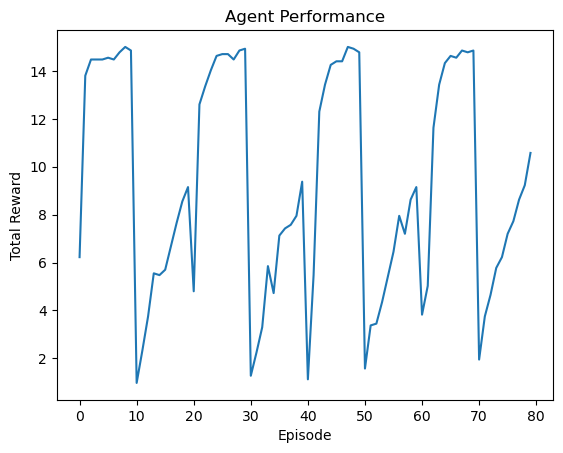

In [4]:
change_every = 2000
n_resets = 8
num_episodes = change_every*n_resets

env.reset(.5,.5,theta0=theta0)
eta = .002

dw_filt=0

agent.weights = np.copy(agent.weights_0*0)
n_angle=0

for episode in range(num_episodes):

    sigma_distribution = 0
    

    
    episode
    states = []
    actions = []
    rewards = []

    STATES = []
    PROBS = []

    env.reset_inner()
    agent.updates_filt_ = np.copy(agent.weights*0.)
    agent.updates_filt = np.copy(agent.weights*0.)

    network_reservoire_gradient.reset()
    network_reservoire.reset()

    #env.reset()
    if ((episode%change_every)==0):
        
        theta0=45*n_angle
        n_angle = n_angle+1
        
        env.reset(.5,.5,theta0=theta0)
        agent.weights = np.copy(agent.weights_0*0)
        
    done = False
    time = 0
    while (not done):
        time = time + 1
        if time > 30:
            break
            
        states = []
        actions = []
        rewards = []

        state = np.copy(env.agent_position)#np.concatenate([env.agent_position])#, 0*(env.food_position - env.agent_position)])

        state_enc = encode_state(state).reshape(2*spatial_res,)
        #action_probs = agent.policy(state)
        logits = agent.weights@state_enc#np.dot(agent.weights,state_enc)
        action_probs = np.exp(logits)/np.sum(np.exp(logits))
        action = np.random.choice(4, p=action_probs)
        states.append(state)
        actions.append(action)


        STATES.append(state)
        PROBS.append(action_probs)

        input = np.concatenate((state_enc,agent.weights.flatten()))
        input = np.reshape(input,(np.shape(input)[0],))

        input_modulation = 1 + gamma_state*network_reservoire.Jin_mult@state
        input_modulation= input_modulation.flatten()
        network_reservoire.step_rate(input,input_modulation,0)

        reward, done = env.step(action)

        #probs = np.copy(action_probs)#agent.policy(state)
        #probs[action] -= 1  # Gradient of log probability
        #e = reward * probs[:, None] 
        #dw_prop =  probs @ state 
        #dw_filt = gamma_rl*dw_filt + (1-gamma)*dw_prop
        #dw = - reward * dw_filt
        rewards.append(reward)
        #agent.weights = agent.weights + eta*dw
        weights_old = np.copy(agent.weights) 
        #dw_fun,state_fun,probs_fun =  agent.update(states, actions, rewards)
        
        #probs = self.policy(state)
        #probs[action] -= 1  # Gradient of log probability
            
        gamma_pg=0.
        for i in range(len(states)):
            
            state = states[i]
            action = actions[i]
            reward = rewards[i]

            #gamma_pg = 0.5

            probs = np.copy(action_probs)
            probs[action] -= 1  # Gradient of log probability
            agent.updates_filt_ = agent.updates_filt_*gamma_pg + (1.-gamma_pg)* np.outer(probs,state_enc)#probs[:, None] @ state.reshape(1, -1)
            
            #agent.weights_0 -= reward*agent.learning_rate * agent.updates_filt_*0.02
            dw_out = np.copy(-reward*agent.learning_rate * agent.updates_filt_)*eta
            agent.weights += dw_out#reward*agent.learning_rate * agent.updates_filt_*0.02
        
        
        r_encoded = encode(reward)

        input_modulation = .1 + gamma_grad*network_reservoire_gradient.Jin_mult*reward
        input_modulation= input_modulation.flatten()

        input = np.concatenate((state_enc ,probs,r_encoded.flatten()))#np.concatenate((env.agent_position,action , probs , [reward] ))#np.concatenate(( network_reservoire_y.S , encoded_e ))
        input = np.reshape(input,(np.shape(input)[0],))

        network_reservoire_gradient.step_rate(input,input_modulation,0)

        x_grad_net_coll.append(network_reservoire_gradient.S)
        #y_grad_coll.append((np.outer(probs,state)).flatten()*0.02)
        y_grad_coll.append(dw_out.flatten())

        x_net_coll.append(network_reservoire.S)
        y_coll.append(logits)#(action_probs-.5)*1.9 )

    total_rewards.append(sum(rewards))

    # Update agent's policy
    #agent.update(states, actions, rewards)
        
    if (episode+1) % 200 == 0:
        print(f"Episode {episode}, Total Reward: {np.mean(total_rewards[-200:])}")
        rew_to_plot.append(np.mean(total_rewards[-200:]))
        #env.reset()


plt.plot(rew_to_plot)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Agent Performance')
plt.show()

(-1.0, 1.0)

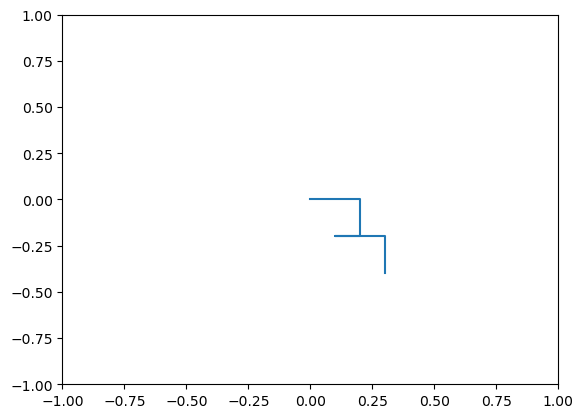

In [5]:
plt.plot(np.array(STATES)[:,0],np.array(STATES)[:,1])
plt.ylim(-1,1)
plt.xlim(-1,1)


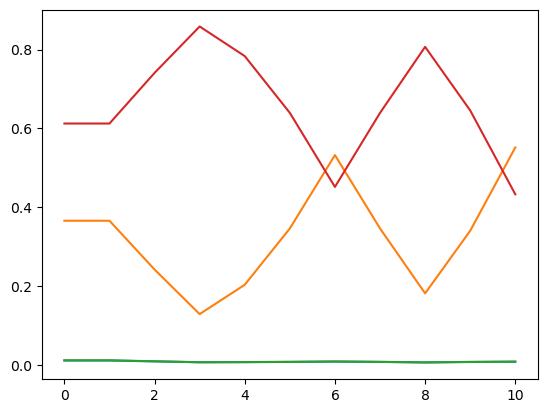

In [6]:
plt.plot(np.array(PROBS)[:,0])
plt.plot(np.array(PROBS)[:,1])
plt.plot(np.array(PROBS)[:,2])
plt.plot(np.array(PROBS)[:,3])


In [7]:
PROBS

[array([0.01079669, 0.36556009, 0.0112442 , 0.61239903]),
 array([0.01079669, 0.36556009, 0.0112442 , 0.61239903]),
 array([0.00858477, 0.24170557, 0.00874077, 0.74096889]),
 array([0.00638134, 0.12857869, 0.00629027, 0.8587497 ]),
 array([0.00670207, 0.20313529, 0.00663905, 0.78352359]),
 array([0.00729222, 0.34601882, 0.00729729, 0.63939167]),
 array([0.00802729, 0.53224293, 0.00829725, 0.45143253]),
 array([0.00729222, 0.34601882, 0.00729729, 0.63939167]),
 array([0.00600435, 0.18122684, 0.0057758 , 0.80699302]),
 array([0.00721007, 0.34017099, 0.00703799, 0.64558095]),
 array([0.00783992, 0.55165945, 0.00779141, 0.43270922])]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


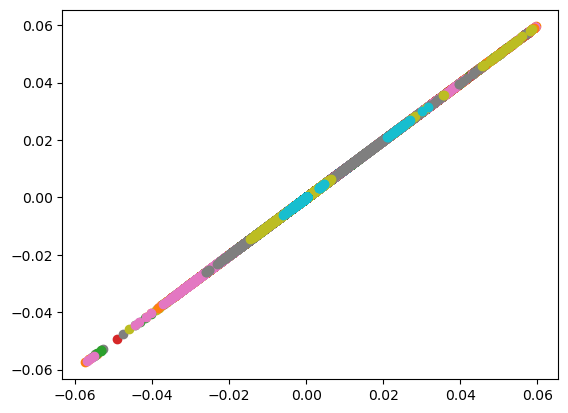

In [8]:
noise_size = 0.0000005
n_steps = np.shape(np.array(y_grad_coll))[1]

for k in range(n_steps):
    print(k)
    W_out = np.linalg.pinv(x_grad_net_coll + np.random.normal(0,noise_size,size= np.shape(x_grad_net_coll) ) ).dot(np.arctanh(np.array(y_grad_coll)[:,k]))
    #W_out = np.linalg.pinv(x_grad_net_coll + np.random.normal(0,noise_size,size= np.shape(x_grad_net_coll) ) ).dot((np.array(y_grad_coll)[:,k]))
    network_reservoire_gradient.Jout[k,:] = np.copy(W_out)
    #network_reservoire_gradient.Jout[k,:] = np.copy(W_out.T)
    plt.scatter(np.tanh(W_out.T@np.array(x_grad_net_coll).T),np.array(y_grad_coll)[:,k])


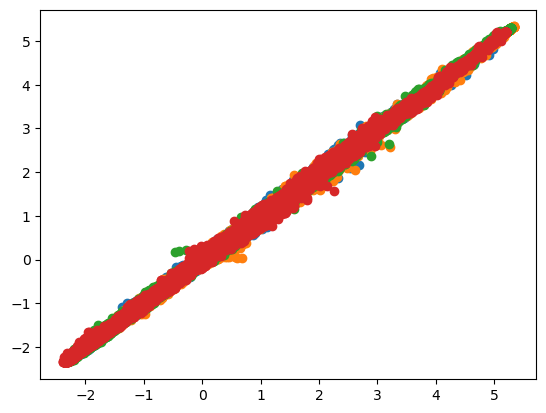

In [9]:
noise_size = 0.00000005
n_steps = np.shape(np.array(y_coll))[1]

for k in range(n_steps):
    #W_out = np.linalg.pinv(x_net_coll + np.random.normal(0,noise_size,size= np.shape(x_net_coll) ) ).dot(np.arctanh(y_coll))
    W_out = np.linalg.pinv(x_net_coll + np.random.normal(0,noise_size,size= np.shape(x_net_coll) ) ).dot((np.array(y_coll)[:,k]))

    network_reservoire.Jout[k,:] = np.copy(W_out.T)
    plt.scatter(W_out.T@np.array(x_net_coll).T,np.array(y_coll)[:,k])


In [10]:
np.shape(y_coll)

(256733, 4)

In [11]:
np.shape(network_reservoire_gradient.Jout)

(40, 500)

In [12]:
sigma_distribution = 0
theta0=90

total_rewards = []

rew_to_plot_net = []

agent.weights = np.copy(agent.weights_0*0)
env.reset(.5,.5,theta0=theta0)

[0.  0.5]


In [13]:
#num_episodes = 25000
#env.reset()
eta = .1*.02

gamma_rl = 0.9
dw_filt=0

#agent.weights = np.copy(agent.weights_0*0)
n_angle=0
for episode in range(num_episodes):
    #print(episode)

    states = []
    actions = []
    rewards = []

    env.reset_inner()
    agent.updates_filt_ = np.copy(agent.weights*0.)
    agent.updates_filt = np.copy(agent.weights*0.)
    
    network_reservoire_gradient.reset()
    network_reservoire.reset()
    
    #env.reset()
    if ((episode%change_every)==0):
        n_angle = n_angle+1
        env.reset(.5,.5,theta0=theta0)
        theta0=45*n_angle
        agent.weights = np.copy(agent.weights_0*0)

    done = False
    time = 0
    while (not done):
        time = time + 1
        if time > 30:
            break
            
        states = []
        actions = []
        rewards = []

        state = np.copy(env.agent_position)#np.concatenate([env.agent_position])#, 0*(env.food_position - env.agent_position)])
        state_enc = encode_state(state).reshape(2*spatial_res,)
        #action_probs = agent.policy(state)


        input = np.concatenate((state_enc ,agent.weights.flatten()))
        input= np.reshape(input,(np.shape(input)[0],))
        input_modulation = 1 + gamma_state*network_reservoire.Jin_mult@state
        input_modulation= input_modulation.flatten()
        network_reservoire.step_rate(input,input_modulation,0,if_tanh=False)
    
        #logits = np.copy( network_reservoire.y)#/2. +.5)
        logits = agent.weights@state_enc
        #action_probs = action_probs/np.sum(action_probs)
        action_probs = np.exp(logits)/np.sum(np.exp(logits))

        #action_probs = agent.policy(state)

        action = np.random.choice(4, p=action_probs)
        states.append(state)
        actions.append(action)

        reward, done = env.step(action)

        #probs = np.copy(action_probs)#agent.policy(state)
        #probs[action] -= 1  # Gradient of log probability
        #e = reward * probs[:, None] 
        #dw_prop =  probs @ state 
        #dw_filt = gamma_rl*dw_filt + (1-gamma)*dw_prop
        #dw = - reward * dw_filt
        rewards.append(reward)
        #agent.weights = agent.weights + eta*dw
        #weights_old = np.copy(agent.weights) 
        #dw_fun,state_fun,probs_fun =  agent.update(states, actions, rewards)
        
        #probs = self.policy(state)
        #probs[action] -= 1  # Gradient of log probability
            
        gamma_pg=0.
        #for i in range(len(states)):
            
        #    state = states[i]
        #    action = actions[i]
        #    reward = rewards[i]
        #    gamma_pg = 0.

        probs = np.copy(action_probs)
        probs[action] -= 1  # Gradient of log probability
        #agent.updates_filt_ = agent.updates_filt_*gamma_pg + (1.-gamma_pg)* np.outer(probs,state)#probs[:, None] @ state.reshape(1, -1)
            
            
        r_encoded = encode(reward)

        input_modulation = .1 + gamma_grad*network_reservoire_gradient.Jin_mult*reward#@probs
        input_modulation= input_modulation.flatten()

        input = np.concatenate((state_enc ,probs,r_encoded.flatten()))#np.concatenate((env.agent_position,action , probs , [reward] ))#np.concatenate(( network_reservoire_y.S , encoded_e ))
        input = np.reshape(input,(np.shape(input)[0],))

        network_reservoire_gradient.step_rate(input,input_modulation,0)

        dw_out = np.copy(np.reshape(network_reservoire_gradient.y,(4,2*spatial_res)))
        agent.weights += dw_out#reward*agent.learning_rate * agent.updates_filt_*0.02


        x_grad_net_coll.append(network_reservoire_gradient.S)
        #y_grad_coll.append((np.outer(probs,state)).flatten()*0.02)
        y_grad_coll.append(dw_out.flatten())

    total_rewards.append(sum(rewards))

    # Update agent's policy
    #agent.update(states, actions, rewards)
        
    if (episode+1) % 200 == 0:
        print(f"Episode {episode}, Total Reward: {np.mean(total_rewards[-200:])}")
        rew_to_plot_net.append(np.mean(total_rewards[-200:]))


[0.  0.5]
Episode 199, Total Reward: 1.425
Episode 399, Total Reward: 3.525
Episode 599, Total Reward: 11.775
Episode 799, Total Reward: 14.025
Episode 999, Total Reward: 13.95
Episode 1199, Total Reward: 14.55
Episode 1399, Total Reward: 14.25
Episode 1599, Total Reward: 14.85
Episode 1799, Total Reward: 14.775
Episode 1999, Total Reward: 14.85
[0.4 0.4]
Episode 2199, Total Reward: 2.4
Episode 2399, Total Reward: 4.575
Episode 2599, Total Reward: 4.65
Episode 2799, Total Reward: 5.7
Episode 2999, Total Reward: 6.45
Episode 3199, Total Reward: 8.475
Episode 3399, Total Reward: 8.025
Episode 3599, Total Reward: 8.775
Episode 3799, Total Reward: 10.05
Episode 3999, Total Reward: 9.525
[0.  0.5]
Episode 4199, Total Reward: 3.825
Episode 4399, Total Reward: 11.4
Episode 4599, Total Reward: 13.875
Episode 4799, Total Reward: 14.475
Episode 4999, Total Reward: 14.85
Episode 5199, Total Reward: 14.775
Episode 5399, Total Reward: 15.0
Episode 5599, Total Reward: 14.775
Episode 5799, Total Rewa

In [14]:
theta0

360

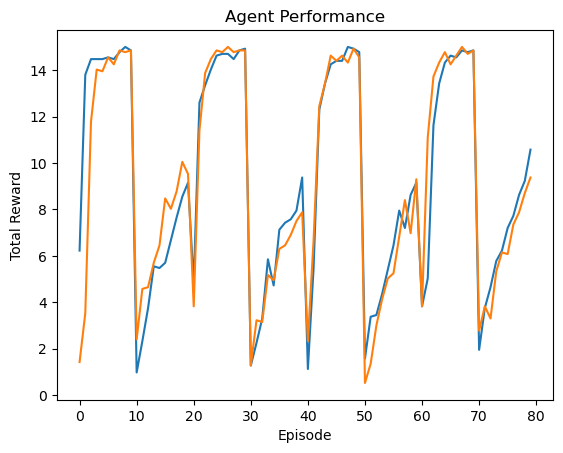

In [15]:
plt.plot(rew_to_plot)
plt.plot(rew_to_plot_net)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Agent Performance')
plt.savefig('dynamics_RL_comparison_2.png')

In [16]:
total_rewards = []
rew_to_plot_net_full = []

agent.weights = np.copy(agent.weights_0*0)
env.reset(.5,.5,theta0=theta0)

[ 0.5 -0. ]


In [17]:
eta = .1*.02

gamma_rl = 0.9
dw_filt=0

#agent.weights = np.copy(agent.weights_0*0)

theta0=0
sigma_distribution = 0
n_angle=0

for episode in range(num_episodes):
    episode
    states = []
    actions = []
    rewards = []

    env.reset_inner()
    agent.updates_filt_ = np.copy(agent.weights*0.)
    agent.updates_filt = np.copy(agent.weights*0.)
   
    
    network_reservoire_gradient.reset()
    network_reservoire.reset()
    
    #env.reset()
    if ((episode%change_every)==0):
        theta0=45*n_angle
        n_angle = n_angle+1
        env.reset(.5,.5,theta0=theta0)
        agent.weights = np.copy(agent.weights_0*0)

    done = False
    time = 0
    while (not done):
        time = time + 1
        if time > 30:
            break
            
        states = []
        actions = []
        rewards = []

        state = np.copy(env.agent_position)#np.concatenate([env.agent_position])#, 0*(env.food_position - env.agent_position)])
        state_enc = encode_state(state).reshape(2*spatial_res,)
        #action_probs = agent.policy(state)


        input = np.concatenate((state_enc ,agent.weights.flatten()))
        input= np.reshape(input,(np.shape(input)[0],))
        input_modulation = 1 + gamma_state*network_reservoire.Jin_mult@state
        input_modulation= input_modulation.flatten()
        network_reservoire.step_rate(input,input_modulation,0,if_tanh=False)
    

        logits = np.copy( network_reservoire.y)#/2. +.5)
        #logits = agent.weights@state_enc
        #action_probs = action_probs/np.sum(action_probs)
        action_probs = np.exp(logits)/np.sum(np.exp(logits))

        action = np.random.choice(4, p=action_probs)
        states.append(state)
        actions.append(action)

        reward, done = env.step(action)

        rewards.append(reward)            
        gamma_pg=0.

        probs = np.copy(action_probs)
        probs[action] -= 1  # Gradient of log probability
            
            
        r_encoded = encode(reward)

        input_modulation = .1 + gamma_grad*network_reservoire_gradient.Jin_mult*reward#@probs
        input_modulation= input_modulation.flatten()

        input = np.concatenate((state_enc ,probs,r_encoded.flatten()))#np.concatenate((env.agent_position,action , probs , [reward] ))#np.concatenate(( network_reservoire_y.S , encoded_e ))
        input = np.reshape(input,(np.shape(input)[0],))

        network_reservoire_gradient.step_rate(input,input_modulation,0)

        dw_out = np.copy(np.reshape(network_reservoire_gradient.y,(4,2*spatial_res)))
        agent.weights += dw_out#reward*agent.learning_rate * agent.updates_filt_*0.02


    total_rewards.append(sum(rewards))

    # Update agent's policy
    #agent.update(states, actions, rewards)
        
    if (episode+1) % 200 == 0:
        print(f"Episode {episode}, Total Reward: {np.mean(total_rewards[-200:])}")
        rew_to_plot_net_full.append(np.mean(total_rewards[-200:]))


[0.5 0. ]
Episode 199, Total Reward: 3.225
Episode 399, Total Reward: 11.475
Episode 599, Total Reward: 13.275
Episode 799, Total Reward: 14.325
Episode 999, Total Reward: 14.4
Episode 1199, Total Reward: 14.55
Episode 1399, Total Reward: 14.475
Episode 1599, Total Reward: 14.775
Episode 1799, Total Reward: 14.775
Episode 1999, Total Reward: 14.55
[0.4 0.4]
Episode 2199, Total Reward: 1.35
Episode 2399, Total Reward: 3.75
Episode 2599, Total Reward: 4.35
Episode 2799, Total Reward: 5.4
Episode 2999, Total Reward: 5.625
Episode 3199, Total Reward: 6.525
Episode 3399, Total Reward: 7.35
Episode 3599, Total Reward: 8.25
Episode 3799, Total Reward: 8.4
Episode 3999, Total Reward: 7.725
[0.  0.5]
Episode 4199, Total Reward: 5.325
Episode 4399, Total Reward: 12.375
Episode 4599, Total Reward: 13.875
Episode 4799, Total Reward: 14.325
Episode 4999, Total Reward: 14.7
Episode 5199, Total Reward: 14.775
Episode 5399, Total Reward: 14.7
Episode 5599, Total Reward: 14.85
Episode 5799, Total Rewar

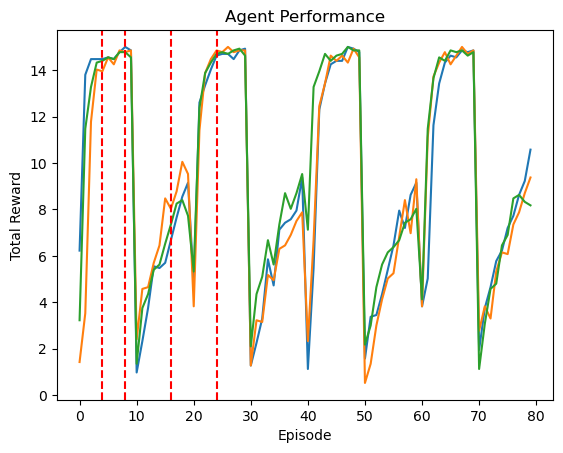

In [18]:
plt.plot(rew_to_plot)
plt.plot(rew_to_plot_net)
plt.plot(rew_to_plot_net_full)
plt.axvline(x=4, color='r', linestyle='--')
plt.axvline(x=8, color='r', linestyle='--')
plt.axvline(x=16, color='r', linestyle='--')
plt.axvline(x=24, color='r', linestyle='--')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Agent Performance')
plt.savefig('dynamics_RL_comparison_2.png')

In [19]:
rew_to_plot_net_full_chunked=np.reshape(np.array(rew_to_plot_net_full),(n_resets,int(change_every/200)))
rew_to_plot_net_chunked=np.reshape(np.array(rew_to_plot_net),(n_resets,int(change_every/200)))
rew_to_plot_chunked=np.reshape(np.array(rew_to_plot),(n_resets,int(change_every/200)))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


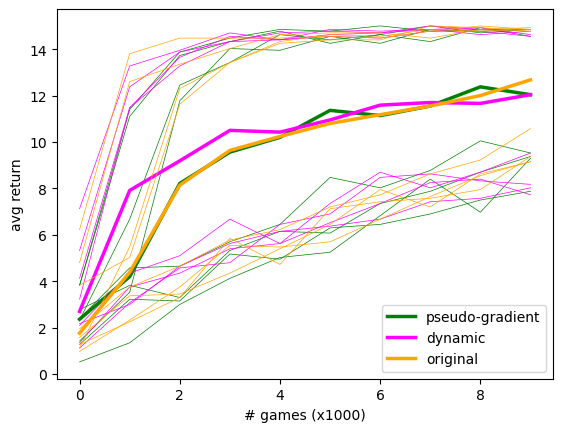

In [20]:
#plt.plot(rew_to_plot_net_chunked.T,'orange')
plt.plot(rew_to_plot_net_chunked.T,'green',linewidth=0.5)
plt.plot(np.median(rew_to_plot_net_chunked.T,axis=1),'green',linewidth=2.5,label='pseudo-gradient')

plt.plot(rew_to_plot_net_full_chunked.T,'magenta',linewidth=0.5)
plt.plot(np.median(rew_to_plot_net_full_chunked.T,axis=1),'magenta',linewidth=2.5,label='dynamic')

plt.plot(rew_to_plot_chunked.T,'orange',linewidth=0.5)
plt.plot(np.median(rew_to_plot_chunked.T,axis=1),'orange',linewidth=2.5,label='original')


plt.legend()
plt.xlabel('# games (x1000)')
plt.ylabel('avg return')
plt.savefig('dynamic_RL_darkroom_5.png')
plt.savefig('dynamic_RL_darkroom_5.eps')

In [21]:
total_rewards = []
rew_to_plot_net_full = []

agent.weights = np.copy(agent.weights_0*0)
env.reset(.5,.5,theta0=theta0)

[ 0.4 -0.4]


In [22]:
change_every = 15000
n_resets = 16
num_episodes = change_every*n_resets

#num_episodes = 25000
#env.reset()


eta = .1*.02

gamma_rl = 0.9
dw_filt=0

#agent.weights = np.copy(agent.weights_0*0)

theta0=0
sigma_distribution = 0
n_angle=0

STATES = []

for episode in range(num_episodes):
    episode
    states = []
    actions = []
    rewards = []

    env.reset_inner()
    agent.updates_filt_ = np.copy(agent.weights*0.)
    agent.updates_filt = np.copy(agent.weights*0.)
   
    
    network_reservoire_gradient.reset()
    network_reservoire.reset()
    
    #env.reset()
    if ((episode%change_every)==0):
        theta0=45/2*n_angle
        n_angle = n_angle+1
        env.reset(.5,.5,theta0=theta0)
        agent.weights = np.copy(agent.weights_0*0)
        
        #if episode>0:
        #    STATES.append(states_)

    done = False
    time = 0
    states_ = []
    while (not done):
        time = time + 1
        if time > 30:
            break
            
        states = []
        actions = []
        rewards = []

        state = np.copy(env.agent_position)#np.concatenate([env.agent_position])#, 0*(env.food_position - env.agent_position)])
        state_enc = encode_state(state).reshape(2*spatial_res,)
        #action_probs = agent.policy(state)

        input = np.concatenate((state_enc ,agent.weights.flatten()))
        input= np.reshape(input,(np.shape(input)[0],))
        input_modulation = 1 + gamma_state*network_reservoire.Jin_mult@state
        input_modulation= input_modulation.flatten()
        network_reservoire.step_rate(input,input_modulation,0,if_tanh=False)
    

        logits = np.copy( network_reservoire.y)#/2. +.5)
        #logits = agent.weights@state_enc
        #action_probs = action_probs/np.sum(action_probs)
        action_probs = np.exp(logits)/np.sum(np.exp(logits))

        action = np.random.choice(4, p=action_probs)
        states.append(state)
        actions.append(action)

        states_.append(state)

        reward, done = env.step(action)

        rewards.append(reward)            
        gamma_pg=0.

        probs = np.copy(action_probs)
        probs[action] -= 1  # Gradient of log probability
            
            
        r_encoded = encode(reward)

        input_modulation = .1 + gamma_grad*network_reservoire_gradient.Jin_mult*reward#@probs
        input_modulation= input_modulation.flatten()

        input = np.concatenate((state_enc ,probs,r_encoded.flatten()))#np.concatenate((env.agent_position,action , probs , [reward] ))#np.concatenate(( network_reservoire_y.S , encoded_e ))
        input = np.reshape(input,(np.shape(input)[0],))

        network_reservoire_gradient.step_rate(input,input_modulation,0)

        dw_out = np.copy(np.reshape(network_reservoire_gradient.y,(4,2*spatial_res)))
        agent.weights += dw_out#reward*agent.learning_rate * agent.updates_filt_*0.02
    
    if (((episode+1)%change_every)==0)&(episode>0):
        STATES.append(states_)

    total_rewards.append(sum(rewards))

    # Update agent's policy
    #agent.update(states, actions, rewards)
        
    if (episode+1) % 200 == 0:
        print(f"Episode {episode}, Total Reward: {np.mean(total_rewards[-200:])}")
        rew_to_plot_net_full.append(np.mean(total_rewards[-200:]))


[0.5 0. ]
Episode 199, Total Reward: 5.4
Episode 399, Total Reward: 12.3
Episode 599, Total Reward: 13.875
Episode 799, Total Reward: 14.55
Episode 999, Total Reward: 14.55
Episode 1199, Total Reward: 14.925
Episode 1399, Total Reward: 14.625
Episode 1599, Total Reward: 14.7
Episode 1799, Total Reward: 14.625
Episode 1999, Total Reward: 14.775
Episode 2199, Total Reward: 14.55
Episode 2399, Total Reward: 14.775
Episode 2599, Total Reward: 14.925
Episode 2799, Total Reward: 14.925
Episode 2999, Total Reward: 14.775
Episode 3199, Total Reward: 14.925
Episode 3399, Total Reward: 14.925
Episode 3599, Total Reward: 15.0
Episode 3799, Total Reward: 14.775
Episode 3999, Total Reward: 14.925
Episode 4199, Total Reward: 14.85
Episode 4399, Total Reward: 14.85
Episode 4599, Total Reward: 14.925
Episode 4799, Total Reward: 15.0
Episode 4999, Total Reward: 14.85
Episode 5199, Total Reward: 15.0
Episode 5399, Total Reward: 15.0
Episode 5599, Total Reward: 14.925
Episode 5799, Total Reward: 14.925
E

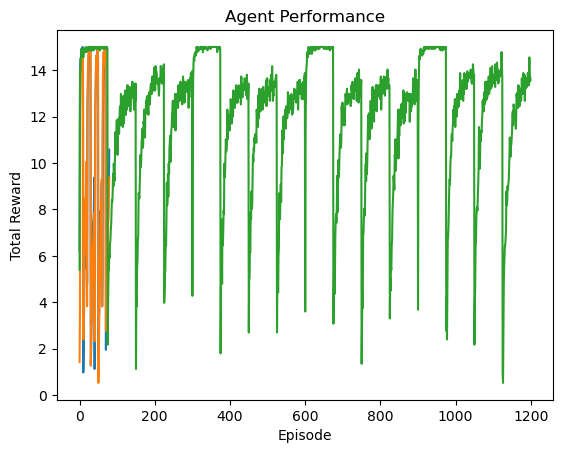

In [23]:
plt.plot(rew_to_plot)
plt.plot(rew_to_plot_net)
plt.plot(rew_to_plot_net_full)
#plt.axvline(x=4, color='r', linestyle='--')
#plt.axvline(x=8, color='r', linestyle='--')
#plt.axvline(x=16, color='r', linestyle='--')
#plt.axvline(x=24, color='r', linestyle='--')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Agent Performance')
plt.savefig('dynamics_RL_comparison_2.png')

In [24]:
rew_to_plot_net_full_chunked=np.reshape(np.array(rew_to_plot_net_full),(n_resets,int(change_every/200)))
#rew_to_plot_net_chunked=np.reshape(np.array(rew_to_plot_net),(n_resets,int(change_every/200)))
#rew_to_plot_chunked=np.reshape(np.array(rew_to_plot),(n_resets,int(change_every/200)))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


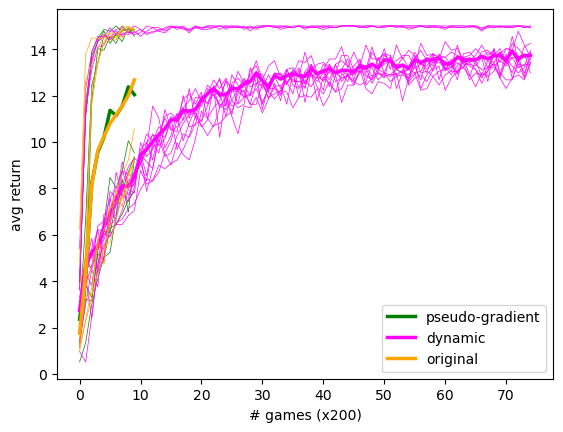

In [25]:
#plt.plot(rew_to_plot_net_chunked.T,'orange')
plt.plot(rew_to_plot_net_chunked.T,'green',linewidth=0.5)
plt.plot(np.median(rew_to_plot_net_chunked.T,axis=1),'green',linewidth=2.5,label='pseudo-gradient')

plt.plot(rew_to_plot_net_full_chunked.T,'magenta',linewidth=0.5)
plt.plot(np.median(rew_to_plot_net_full_chunked.T,axis=1),'magenta',linewidth=2.5,label='dynamic')

plt.plot(rew_to_plot_chunked.T,'orange',linewidth=0.5)
plt.plot(np.median(rew_to_plot_chunked.T,axis=1),'orange',linewidth=2.5,label='original')


plt.legend()
plt.xlabel('# games (x200)')
plt.ylabel('avg return')
plt.savefig('dynamic_RL_darkroom_10_.png')
plt.savefig('dynamic_RL_darkroom_10_.eps')

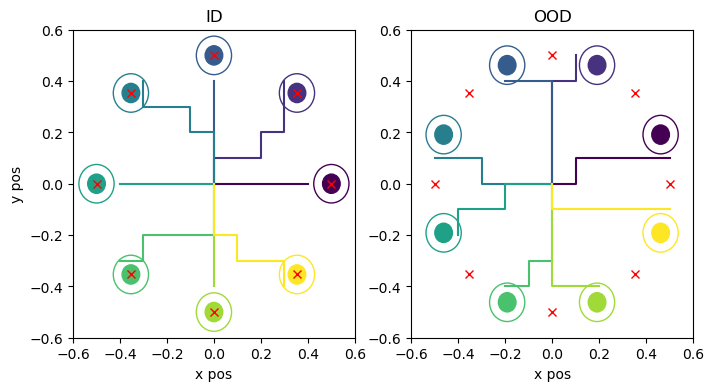

In [26]:
plt.figure(figsize=(8,4))
plt.subplot(121)
colors = cm.viridis(np.linspace(0, 1, 8))

radius = 0.075/2

for k in range(int(len(STATES)/2)):
    plt.plot(np.array(STATES[k*2])[:,0],np.array(STATES[k*2])[:,1],color=colors[k])
    x0=0.5*np.cos((k*45 )/180*np.pi)
    y0=0.5*np.sin((k*45)/180*np.pi)
    circle=plt.Circle((x0, y0), radius, color=colors[k], fill=True)
    plt.gca().add_patch(circle)

    circle=plt.Circle((x0, y0), radius*2, color=colors[k], fill=False)
    plt.gca().add_patch(circle)

for k in range(8):
    #plt.plot(np.array(STATES[k])[:,0],np.array(STATES[k])[:,1],color=colors[k])
    plt.plot(0.5*np.cos(k*45/180*np.pi), 0.5*np.sin(k*45/180*np.pi),'xr' )

plt.xlabel('x pos')
plt.ylabel('y pos')

plt.ylim(-.6,.6)
plt.xlim(-.6,.6)

plt.title('ID')

plt.subplot(122)

plt.title('OOD')

colors = cm.viridis(np.linspace(0, 1, 8))


for k in range(int(len(STATES)/2)):
    plt.plot(np.array(STATES[k*2+1])[:,0],np.array(STATES[k*2+1])[:,1],color=colors[k])

    x0=0.5*np.cos((k*45 + 45/2)/180*np.pi)
    y0=0.5*np.sin((k*45 + 45/2)/180*np.pi)
    circle=plt.Circle((x0, y0), radius, color=colors[k], fill=True)
    plt.gca().add_patch(circle)

    circle=plt.Circle((x0, y0), radius*2, color=colors[k], fill=False)
    plt.gca().add_patch(circle)

    #plt.plot(0.5*np.cos((k*45 + 45/2)/180*np.pi), 0.5*np.sin((k*45 + 45/2)/180*np.pi),'o',color=colors[k] )

for k in range(8):
    #plt.plot(np.array(STATES[k])[:,0],np.array(STATES[k])[:,1],color=colors[k])
    plt.plot(0.5*np.cos(k*45/180*np.pi), 0.5*np.sin(k*45/180*np.pi),'xr' )
plt.ylim(-.6,.6)
plt.xlim(-.6,.6)


plt.xlabel('x pos')
#plt.ylabel('y pos')
plt.savefig('dynamical_darkroom_10_.png')
plt.savefig('dynamical_darkroom_10_.eps')

In [27]:
total_rewards = []
rew_to_plot_net_full_long = []

agent.weights = np.copy(agent.weights_0*0)
env.reset(.5,.5,theta0=theta0)

[ 0.5 -0.2]


In [28]:
change_every = 5000
n_resets = 4
num_episodes = change_every*n_resets

#env.reset()
eta = .1*.02

gamma_rl = 0.9
dw_filt=0

#agent.weights = np.copy(agent.weights_0*0)

for episode in range(num_episodes):
    episode
    states = []
    actions = []
    rewards = []

    env.reset_inner()
    agent.updates_filt_ = np.copy(agent.weights*0.)
    agent.updates_filt = np.copy(agent.weights*0.)
   
    
    network_reservoire_gradient.reset()
    network_reservoire.reset()
    
    #env.reset()
    if ((episode%change_every)==0):
        env.reset(.5,.5,theta0=theta0)
        agent.weights = np.copy(agent.weights_0*0)

    done = False
    time = 0
    while (not done):
        time = time + 1
        if time > 30:
            break
            
        states = []
        actions = []
        rewards = []

        state = np.copy(env.agent_position)#np.concatenate([env.agent_position])#, 0*(env.food_position - env.agent_position)])
        state_enc = encode_state(state).reshape(2*spatial_res,)
        #action_probs = agent.policy(state)


        input = np.concatenate((state_enc ,agent.weights.flatten()))
        input= np.reshape(input,(np.shape(input)[0],))
        input_modulation = 1 + gamma_state*network_reservoire.Jin_mult@state
        input_modulation= input_modulation.flatten()
        network_reservoire.step_rate(input,input_modulation,0,if_tanh=False)
    

        logits = np.copy( network_reservoire.y)#/2. +.5)
        #logits = agent.weights@state_enc
        #action_probs = action_probs/np.sum(action_probs)
        action_probs = np.exp(logits)/np.sum(np.exp(logits))

        action = np.random.choice(4, p=action_probs)
        states.append(state)
        actions.append(action)

        reward, done = env.step(action)

        #probs = np.copy(action_probs)#agent.policy(state)
        #probs[action] -= 1  # Gradient of log probability
        #e = reward * probs[:, None] 
        #dw_prop =  probs @ state 
        #dw_filt = gamma_rl*dw_filt + (1-gamma)*dw_prop
        #dw = - reward * dw_filt
        rewards.append(reward)
        #agent.weights = agent.weights + eta*dw
        #weights_old = np.copy(agent.weights) 
        #dw_fun,state_fun,probs_fun =  agent.update(states, actions, rewards)
        
        #probs = self.policy(state)
        #probs[action] -= 1  # Gradient of log probability
            
        gamma_pg=0.
        #for i in range(len(states)):
            
        #    state = states[i]
        #    action = actions[i]
        #    reward = rewards[i]
        #    gamma_pg = 0.

        probs = np.copy(action_probs)
        probs[action] -= 1  # Gradient of log probability
        #agent.updates_filt_ = agent.updates_filt_*gamma_pg + (1.-gamma_pg)* np.outer(probs,state)#probs[:, None] @ state.reshape(1, -1)
            
            
        r_encoded = encode(reward)

        input_modulation = .1 + gamma_grad*network_reservoire_gradient.Jin_mult*reward#@probs
        input_modulation= input_modulation.flatten()

        input = np.concatenate((state_enc ,probs,r_encoded.flatten()))#np.concatenate((env.agent_position,action , probs , [reward] ))#np.concatenate(( network_reservoire_y.S , encoded_e ))
        input = np.reshape(input,(np.shape(input)[0],))

        network_reservoire_gradient.step_rate(input,input_modulation,0)

        dw_out = np.copy(np.reshape(network_reservoire_gradient.y,(4,2*spatial_res)))
        agent.weights += dw_out#reward*agent.learning_rate * agent.updates_filt_*0.02


        x_grad_net_coll.append(network_reservoire_gradient.S)
        #y_grad_coll.append((np.outer(probs,state)).flatten()*0.02)
        y_grad_coll.append(dw_out.flatten())

    total_rewards.append(sum(rewards))

    # Update agent's policy
    #agent.update(states, actions, rewards)
        
    if (episode+1) % 200 == 0:
        print(f"Episode {episode}, Total Reward: {np.mean(total_rewards[-200:])}")
        rew_to_plot_net_full_long.append(np.mean(total_rewards[-200:]))


[ 0.5 -0.2]
Episode 199, Total Reward: 2.475
Episode 399, Total Reward: 5.025
Episode 599, Total Reward: 5.175
Episode 799, Total Reward: 5.025
Episode 999, Total Reward: 7.425
Episode 1199, Total Reward: 7.125
Episode 1399, Total Reward: 6.075
Episode 1599, Total Reward: 6.9
Episode 1799, Total Reward: 8.4
Episode 1999, Total Reward: 7.725
Episode 2199, Total Reward: 8.1
Episode 2399, Total Reward: 8.775
Episode 2599, Total Reward: 8.775
Episode 2799, Total Reward: 9.3
Episode 2999, Total Reward: 10.35
Episode 3199, Total Reward: 9.975
Episode 3399, Total Reward: 9.9
Episode 3599, Total Reward: 10.575
Episode 3799, Total Reward: 9.375
Episode 3999, Total Reward: 11.4
Episode 4199, Total Reward: 11.175
Episode 4399, Total Reward: 11.25
Episode 4599, Total Reward: 11.55
Episode 4799, Total Reward: 11.25
Episode 4999, Total Reward: 11.55
[ 0.5 -0.2]
Episode 5199, Total Reward: 0.975
Episode 5399, Total Reward: 2.4
Episode 5599, Total Reward: 4.05
Episode 5799, Total Reward: 4.8
Episode 5

In [29]:
rew_to_plot_net_full_chunked_long=np.reshape(np.array(rew_to_plot_net_full_long),(n_resets,int(change_every/200) ))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


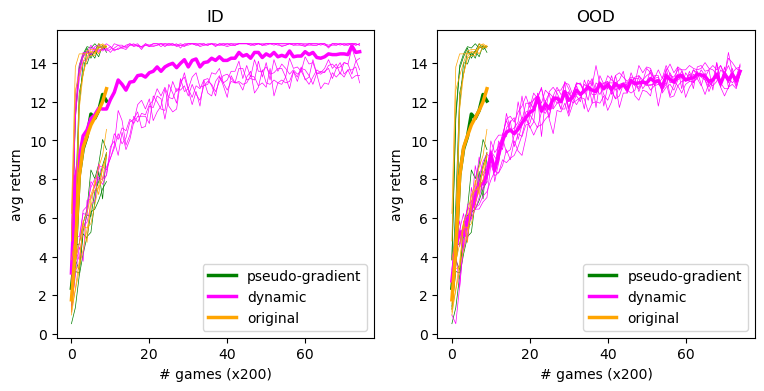

In [30]:
#plt.plot(rew_to_plot_net_chunked.T,'orange')
plt.figure(figsize=(9,4))

plt.subplot(121)
plt.plot(rew_to_plot_net_chunked.T,'green',linewidth=0.5)
plt.plot(np.median(rew_to_plot_net_chunked.T,axis=1),'green',linewidth=2.5,label='pseudo-gradient')

plt.plot(rew_to_plot_net_full_chunked[::2,:].T,'magenta',linewidth=0.5)
plt.plot(np.median(rew_to_plot_net_full_chunked[::2,:].T,axis=1),'magenta',linewidth=2.5,label='dynamic')

plt.plot(rew_to_plot_chunked.T,'orange',linewidth=0.5)
plt.plot(np.median(rew_to_plot_chunked.T,axis=1),'orange',linewidth=2.5,label='original')


plt.legend()
plt.xlabel('# games (x200)')
plt.ylabel('avg return')

plt.title('ID')


plt.subplot(122)


plt.plot(rew_to_plot_net_chunked.T,'green',linewidth=0.5)
plt.plot(np.median(rew_to_plot_net_chunked.T,axis=1),'green',linewidth=2.5,label='pseudo-gradient')

plt.plot(rew_to_plot_net_full_chunked[1::2,:].T,'magenta',linewidth=0.5)
plt.plot(np.median(rew_to_plot_net_full_chunked[1::2,:].T,axis=1),'magenta',linewidth=2.5,label='dynamic')

plt.plot(rew_to_plot_chunked.T,'orange',linewidth=0.5)
plt.plot(np.median(rew_to_plot_chunked.T,axis=1),'orange',linewidth=2.5,label='original')


plt.legend()
plt.xlabel('# games (x200)')
plt.ylabel('avg return')

plt.title('OOD')

plt.savefig('dynamic_RL_darkroom_16_gamma' + str(gamma_state) + '.png')
plt.savefig('dynamic_RL_darkroom_16_gamma' + str(gamma_state) + '.eps')

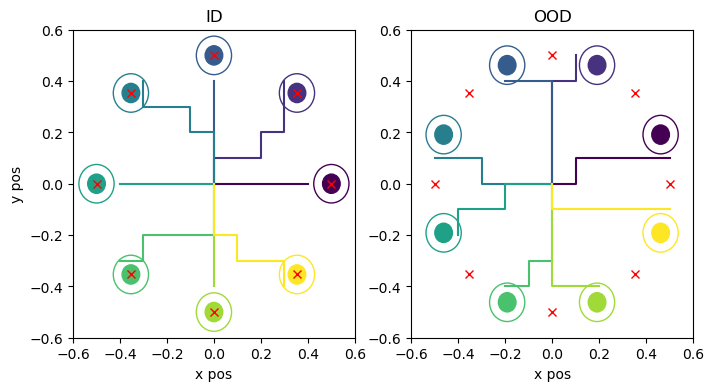

In [31]:
plt.figure(figsize=(8,4))
plt.subplot(121)
colors = cm.viridis(np.linspace(0, 1, 8))

radius = 0.075/2

for k in range(int(len(STATES)/2)):
    plt.plot(np.array(STATES[k*2])[:,0],np.array(STATES[k*2])[:,1],color=colors[k])
    x0=0.5*np.cos((k*45 )/180*np.pi)
    y0=0.5*np.sin((k*45)/180*np.pi)
    circle=plt.Circle((x0, y0), radius, color=colors[k], fill=True)
    plt.gca().add_patch(circle)

    circle=plt.Circle((x0, y0), radius*2, color=colors[k], fill=False)
    plt.gca().add_patch(circle)

for k in range(8):
    #plt.plot(np.array(STATES[k])[:,0],np.array(STATES[k])[:,1],color=colors[k])
    plt.plot(0.5*np.cos(k*45/180*np.pi), 0.5*np.sin(k*45/180*np.pi),'xr' )

plt.xlabel('x pos')
plt.ylabel('y pos')

plt.ylim(-.6,.6)
plt.xlim(-.6,.6)

plt.title('ID')

plt.subplot(122)

plt.title('OOD')

colors = cm.viridis(np.linspace(0, 1, 8))


for k in range(int(len(STATES)/2)):
    plt.plot(np.array(STATES[k*2+1])[:,0],np.array(STATES[k*2+1])[:,1],color=colors[k])

    x0=0.5*np.cos((k*45 + 45/2)/180*np.pi)
    y0=0.5*np.sin((k*45 + 45/2)/180*np.pi)
    circle=plt.Circle((x0, y0), radius, color=colors[k], fill=True)
    plt.gca().add_patch(circle)

    circle=plt.Circle((x0, y0), radius*2, color=colors[k], fill=False)
    plt.gca().add_patch(circle)

    #plt.plot(0.5*np.cos((k*45 + 45/2)/180*np.pi), 0.5*np.sin((k*45 + 45/2)/180*np.pi),'o',color=colors[k] )

for k in range(8):
    #plt.plot(np.array(STATES[k])[:,0],np.array(STATES[k])[:,1],color=colors[k])
    plt.plot(0.5*np.cos(k*45/180*np.pi), 0.5*np.sin(k*45/180*np.pi),'xr' )
plt.ylim(-.6,.6)
plt.xlim(-.6,.6)


plt.xlabel('x pos')
#plt.ylabel('y pos')
plt.savefig('dynamical_darkroom_16_.png')
plt.savefig('dynamical_darkroom_16_.eps')

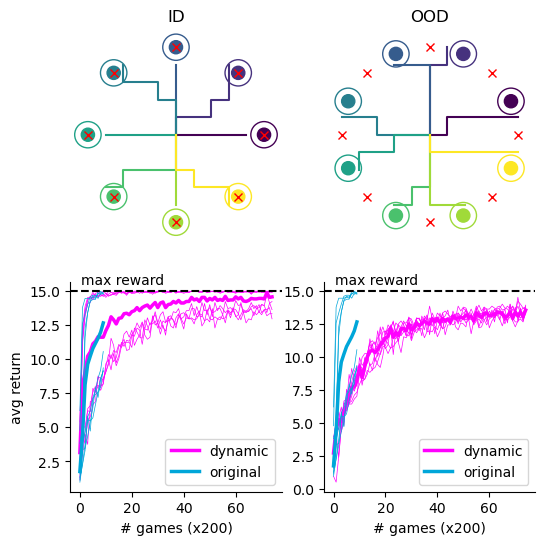

In [32]:
plt.figure(figsize=(6,6))

light_blue = [.0,.65,.85]    
description = ''


plt.subplot(221)
colors = cm.viridis(np.linspace(0, 1, 8))

radius = 0.075/2

for k in range(int(len(STATES)/2)):
    plt.plot(np.array(STATES[k*2])[:,0],np.array(STATES[k*2])[:,1],color=colors[k])
    x0=0.5*np.cos((k*45 )/180*np.pi)
    y0=0.5*np.sin((k*45)/180*np.pi)
    circle=plt.Circle((x0, y0), radius, color=colors[k], fill=True)
    plt.gca().add_patch(circle)

    circle=plt.Circle((x0, y0), radius*2, color=colors[k], fill=False)
    plt.gca().add_patch(circle)

for k in range(8):
    #plt.plot(np.array(STATES[k])[:,0],np.array(STATES[k])[:,1],color=colors[k])
    plt.plot(0.5*np.cos(k*45/180*np.pi), 0.5*np.sin(k*45/180*np.pi),'xr' )

#plt.xlabel('x pos')
#plt.ylabel('y pos')

plt.ylim(-.6,.6)
plt.xlim(-.6,.6)

plt.title('ID')

plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(222)

plt.title('OOD')

colors = cm.viridis(np.linspace(0, 1, 8))


for k in range(int(len(STATES)/2)):
    plt.plot(np.array(STATES[k*2+1])[:,0],np.array(STATES[k*2+1])[:,1],color=colors[k])

    x0=0.5*np.cos((k*45 + 45/2)/180*np.pi)
    y0=0.5*np.sin((k*45 + 45/2)/180*np.pi)
    circle=plt.Circle((x0, y0), radius, color=colors[k], fill=True)
    plt.gca().add_patch(circle)

    circle=plt.Circle((x0, y0), radius*2, color=colors[k], fill=False)
    plt.gca().add_patch(circle)

    #plt.plot(0.5*np.cos((k*45 + 45/2)/180*np.pi), 0.5*np.sin((k*45 + 45/2)/180*np.pi),'o',color=colors[k] )

for k in range(8):
    #plt.plot(np.array(STATES[k])[:,0],np.array(STATES[k])[:,1],color=colors[k])
    plt.plot(0.5*np.cos(k*45/180*np.pi), 0.5*np.sin(k*45/180*np.pi),'xr' )
plt.ylim(-.6,.6)
plt.xlim(-.6,.6)

plt.xticks([])
plt.yticks([])
plt.axis('off')
#plt.xlabel('x pos')
#plt.ylabel('y pos')

plt.subplot(223)
#plt.plot(rew_to_plot_net_chunked.T,'green',linewidth=0.5)
#plt.plot(np.median(rew_to_plot_net_chunked.T,axis=1),'green',linewidth=2.5,label='pseudo-gradient')

plt.plot(rew_to_plot_net_full_chunked[::2,:].T,'magenta',linewidth=0.5)
plt.plot(np.median(rew_to_plot_net_full_chunked[::2,:].T,axis=1),'magenta',linewidth=2.5,label='dynamic')

plt.plot(rew_to_plot_chunked.T,color=light_blue,linewidth=0.5)
plt.plot(np.median(rew_to_plot_chunked.T,axis=1),color=light_blue,linewidth=2.5,label='original')


plt.legend()
plt.xlabel('# games (x200)')
plt.ylabel('avg return')
plt.axhline(y=15, color='black', linestyle='--')
plt.text(0.5, 15.5, 'max reward', color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.title('ID')


plt.subplot(224)


#plt.plot(rew_to_plot_net_chunked.T,'green',linewidth=0.5)
#plt.plot(np.median(rew_to_plot_net_chunked.T,axis=1),'green',linewidth=2.5,label='pseudo-gradient')

plt.plot(rew_to_plot_net_full_chunked[1::2,:].T,'magenta',linewidth=0.5)
plt.plot(np.median(rew_to_plot_net_full_chunked[1::2,:].T,axis=1),'magenta',linewidth=2.5,label='dynamic')

plt.plot(rew_to_plot_chunked.T,color=light_blue,linewidth=0.5)
plt.plot(np.median(rew_to_plot_chunked.T,axis=1),color=light_blue,linewidth=2.5,label='original')


plt.axhline(y=15, color='black', linestyle='--')
plt.text(0.5, 15.5, 'max reward', color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()
plt.xlabel('# games (x200)')
#plt.yticks([])
#plt.ylabel('avg return')


#plt.savefig('dynamic_RL_darkroom_19_gamma' + str(gamma_state) + 'gamma_pg' + str(gamma_pg) + description + '.png')
plt.savefig('dynamic_RL_darkroom_19_gamma' + str(gamma_state) + 'gamma_pg' + str(gamma_pg) + description + '.pdf')
